In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
# Loading in the training and testing dataset
train_users = pd.read_csv('./train_users_2.csv')
test_users = pd.read_csv('./test_users.csv')
print 'There are %d data points in the training set, %d in the test set, %d in total.' % (train_users.shape[0], test_users.shape[0], train_users.shape[0] + test_users.shape[0])
print train_users.columns
print test_users.columns

There are 213451 data points in the training set, 62096 in the test set, 275547 in total.
Index([u'id', u'date_account_created', u'timestamp_first_active',
       u'date_first_booking', u'gender', u'age', u'signup_method',
       u'signup_flow', u'language', u'affiliate_channel',
       u'affiliate_provider', u'first_affiliate_tracked', u'signup_app',
       u'first_device_type', u'first_browser', u'country_destination'],
      dtype='object')
Index([u'id', u'date_account_created', u'timestamp_first_active',
       u'date_first_booking', u'gender', u'age', u'signup_method',
       u'signup_flow', u'language', u'affiliate_channel',
       u'affiliate_provider', u'first_affiliate_tracked', u'signup_app',
       u'first_device_type', u'first_browser'],
      dtype='object')


# Data exploration

In [89]:
# Now take a look at the training set
users = pd.concat([train_users, test_users], axis=0,ignore_index=True)
users.drop('id', axis=1,inplace=True)
users.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,facebook,20090319043255
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,en,Web,0,facebook,20090523174809
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,en,Web,3,basic,20090609231247
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,en,Web,0,facebook,20091031060129
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,basic,20091208061105


In [90]:
# Now lets take a look at gender
print 'There are %d users with unknown gender' % (users[users['gender'] == '-unknown-'].shape[0])
users['gender'].replace('-unknown-', np.nan, inplace=True)
print 'Now valid user count is %d' % (users.shape[0])

There are 129480 users with unknown gender
Now valid user count is 275547


In [91]:
# Now lets look at how much data is missing
users_nan = (users.isnull().sum() / users.shape[0]) * 100
users_nan[users_nan > 0]
# So there is quite a lot of data missing

age                        42.412365
country_destination        22.535538
date_first_booking         67.733998
first_affiliate_tracked     2.208335
gender                     46.990169
dtype: float64

In [92]:
print 'Number of users with finite age is %d' % (users[np.isfinite(users['age'])].shape[0])
print 'Number of users older than 90 is %d' % (users[users['age'] > 90].shape[0])
print 'Number of users younger than 18 is %d' % (users[users['age'] < 18].shape[0])

Number of users with finite age is 158681
Number of users older than 90 is 2928
Number of users younger than 18 is 188


In [93]:
very_old_users = users[users['age'] > 90]
very_young_users = users[users['age'] < 13]
very_old_users['age'].describe()

count    2928.000000
mean      642.572063
std       857.062041
min        91.000000
25%       105.000000
50%       105.000000
75%      2013.000000
max      2014.000000
Name: age, dtype: float64

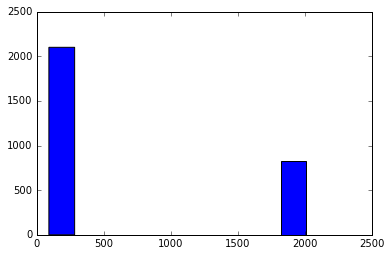

In [94]:
n, bins, patches = plt.hist(very_old_users['age'], bins = 10)

In [95]:
# Make invalid ages nan
users.loc[users['age'] > 95] = np.nan
users.loc[users['age'] < 16] = np.nan

In [97]:
# Now lets look at the categorical data
categorical = ['affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'first_browser'
              , 'first_device_type', 'gender', 'language', 'signup_app', 'signup_flow', 'signup_method']
for category in categorical:
    users[category] = users[category].astype('category')
users.ix[0:4,categorical[0]]

0    direct
1       seo
2    direct
3    direct
4    direct
Name: affiliate_channel, dtype: category
Categories (8, object): [api, content, direct, other, remarketing, sem-brand, sem-non-brand, seo]

In [114]:
users = users[~np.isnan(users['timestamp_first_active'])]
print "Now we have %d valid users." % (users.shape[0])

Now we have 272682 valid users.


In [118]:
# Now lets take care of the date and time data
users['date_account_created'] = pd.to_datetime(users['date_account_created'])
users['date_first_booking'] = pd.to_datetime(users['date_first_booking'])
users['timestamp_first_active'] = users['timestamp_first_active'].astype(int)
users['timestamp_first_active'] = pd.to_datetime((users['timestamp_first_active']//1000000), format='%Y%m%d')

In [121]:
# Now lets look at the types of our data
print users.dtypes

affiliate_channel                category
affiliate_provider               category
age                               float64
country_destination                object
date_account_created       datetime64[ns]
date_first_booking         datetime64[ns]
first_affiliate_tracked          category
first_browser                    category
first_device_type                category
gender                           category
language                         category
signup_app                       category
signup_flow                      category
signup_method                    category
timestamp_first_active     datetime64[ns]
dtype: object


# Visualization of features

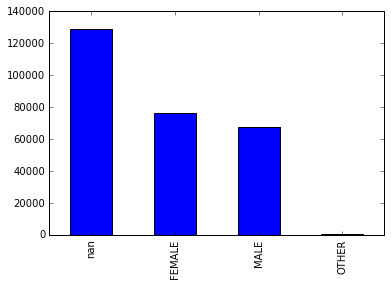

In [126]:
# Gender
users['gender'].value_counts(dropna=False).plot(kind='bar')

In [167]:
def printPercentage(df1, df2, label1, label2):
    def convertToPrctg(series):
        return series.value_counts() / sum(series.value_counts()) * 100
    df1_dest = convertToPrctg(df1['country_destination'])
    df2_dest = convertToPrctg(df2['country_destination'])
    df1_dest.plot(kind='bar', width=0.4, color='yellow', position=0, label=label1)
    df2_dest.plot(kind='bar', width=0.4, color='green', position=1, label=label2)
    
    plt.legend()
    plt.xlabel('Destination')
    plt.ylabel('Perncentage')

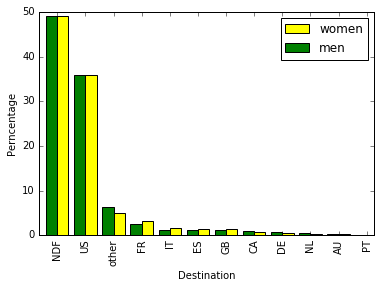

In [168]:
women = users[users['gender'] == 'FEMALE']
men = users[users['gender'] == 'MALE']
printPercentage(women, men, 'women', 'men')

There is not much difference between the two genders, so it might not be a vary good indicator.

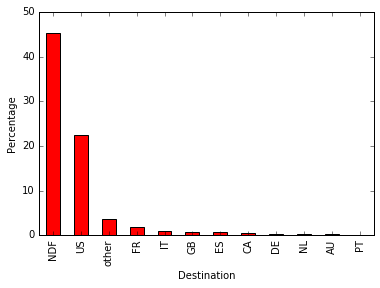

In [135]:
dest = users['country_destination'].value_counts() / users.shape[0] * 100
dest.plot(kind='bar', color='red')
plt.xlabel('Destination')
plt.ylabel('Percentage')

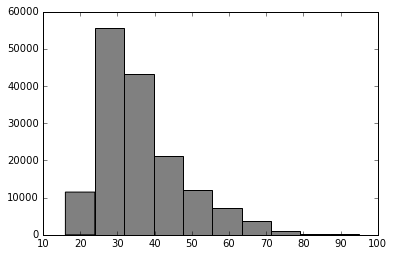

In [138]:
# Take a look at the difference among ages
n, bins, patches = plt.hist(users['age'].dropna(), bins=10, color='gray')

We can see that majority of users are from 30 to 40 years old

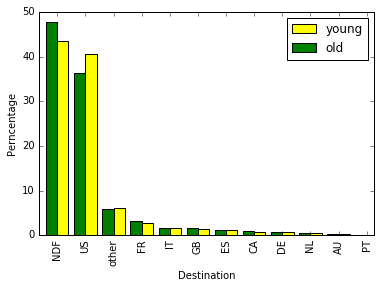

In [169]:
# Lets set an age separator and look at the destination distribution
AGE = 35
young = users[users['age']<= AGE]
old = users[users['age']>AGE]
printPercentage(young, old, 'young', 'old')

There is not much difference in destination for young and old users either

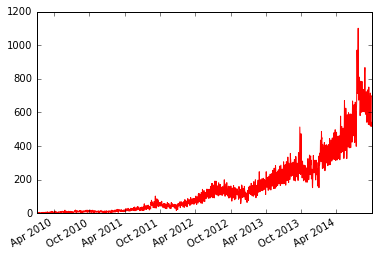

In [146]:
# Now lets take a look at different dates
users['date_account_created'].value_counts().plot(kind='line', color='red')

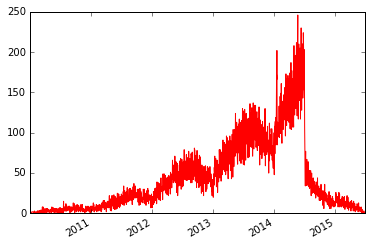

In [149]:
users['date_first_booking'].value_counts().plot(kind='line', color='red')

It seems that account creation and booking events have some time pattern, let us take a closer look into time pattern with destination.

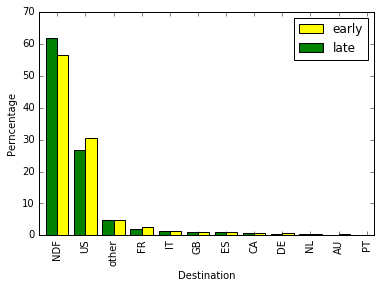

In [170]:
DATE = pd.to_datetime('2014-01-01')
early = users[users['date_account_created'] <= DATE]
late = users[users['date_account_created'] > DATE]

printPercentage(early, late, 'early', 'late')

We can see that later users tend not to book, and when they book, most of them will stay in US, so this is a good indicator.

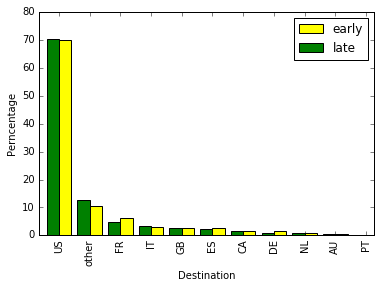

In [171]:
early_booking = users[users['date_first_booking'] <= DATE]
late_booking = users[users['date_first_booking'] > DATE]
printPercentage(early_booking, late_booking, 'early', 'late')

There is not much difference in terms of date first booking.

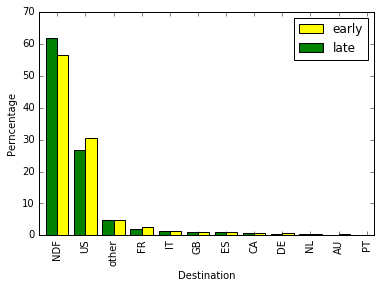

In [172]:
early_active = users[users['timestamp_first_active'] <= DATE]
late_active = users[users['timestamp_first_active'] > DATE]
printPercentage(early_active, late_active, 'early', 'late')

This is consistent with date account created, as early people tend to book more and stay in the US more.

In [166]:
print early['country_destination'].value_counts() / early.shape[0] * 100
print sum(late['country_destination'].value_counts()), late.shape[0]

NDF      56.577810
US       30.505145
other     4.655543
FR        2.602170
IT        1.339124
GB        1.152991
ES        1.120492
CA        0.711294
DE        0.584990
NL        0.370789
AU        0.281415
PT        0.098237
Name: country_destination, dtype: float64
75561 137295
